In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

import skfuzzy as fuzz

from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.spatial.distance import cdist

In [38]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz

# Load example data (Iris dataset, 150 samples, 4 features)
data = load_iris()
X = data.data

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Transpose for skfuzzy (expects features x samples)
X_scaled_T = X_scaled.T

# Fuzzy C-Means clustering
n_clusters = 3
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled_T, c=n_clusters, m=2, error=0.005, maxiter=1000, seed=42
)

# Get the cluster label for each data point
labels = np.argmax(u, axis=0)

# Show labels
print("Cluster labels:", labels)


Cluster labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 1]


In [39]:
df = pd.read_csv("./data/winequality-red.csv", sep=';')
data = df.drop(columns=["quality"])

# Normalization
minmax_scaler = MinMaxScaler()
data_minmax = minmax_scaler.fit_transform(data)

zscore_scaler = StandardScaler()
data_zscore = zscore_scaler.fit_transform(data)


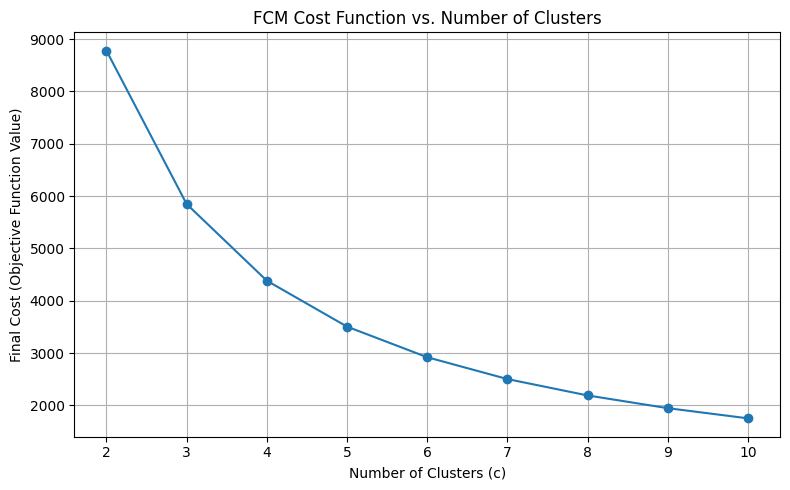

In [40]:
# b)
X = data_zscore.T  # Note: skfuzzy expects features as rows and samples as columns

# Fuzzy C-Means Clustering with different cluster counts
c_range = range(2, 11)  # c = 2 to 10
cost_values = []

for c in c_range:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X, c, m=2, error=0.005, maxiter=1000, init=None, seed=42
    )
    cost_values.append(jm[-1])  # final objective function value

# Plot cost function vs. number of clusters
plt.figure(figsize=(8, 5))
plt.plot(list(c_range), cost_values, marker='o')
plt.title("FCM Cost Function vs. Number of Clusters")
plt.xlabel("Number of Clusters (c)")
plt.ylabel("Final Cost (Objective Function Value)")
plt.grid(True)
plt.tight_layout()
plt.show()

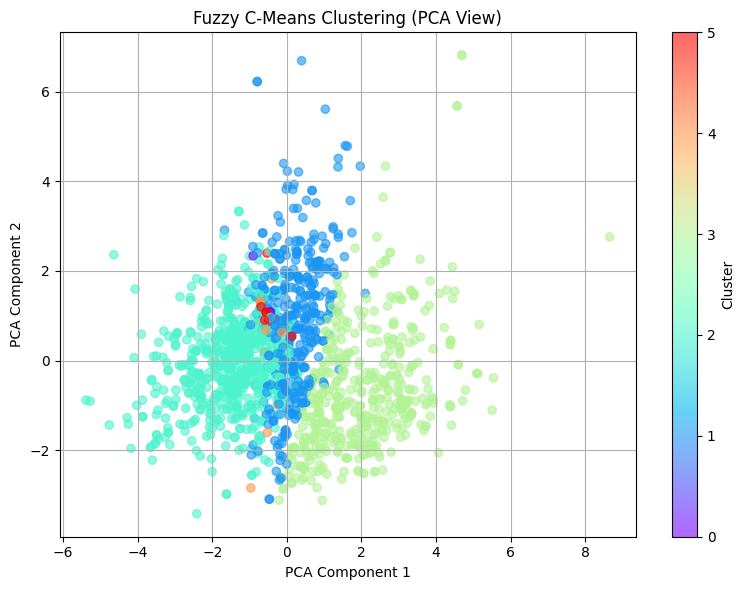

In [44]:

data_scaled = data_zscore


# Step 1: KMeans to get initial centers
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data_scaled)
initial_centers = kmeans.cluster_centers_  # shape: (6, 11)


# Step 2: Fuzzy C-Means with KMeans init
data_for_fcm = data_scaled.T  # shape: (11, 1599)

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data=data_for_fcm,
    c=n_clusters,
    m=2,
    error=0.005,
    maxiter=1000,
    #init=initial_centers,
    seed=42
)


# Step 3: FCM cluster labels
fuzzy_labels = np.argmax(u, axis=0)  # shape: (1599,)

# Step 4: PCA for 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)  # shape: (1599, 2)

# Step 5: Plot the clustering result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=fuzzy_labels, cmap='rainbow', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title("Fuzzy C-Means Clustering (PCA View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()



In [45]:
# f) Validation Indices

# Defuzzify: convert membership matrix to hard labels
labels_fcm = np.argmax(u, axis=0)

# Adjust Rand Index - compare to original wine 'quality' column
ari = adjusted_rand_score(df['quality'], labels_fcm)

# Silhouette score (on standardized data)
sil_score = silhouette_score(data_scaled, labels_fcm)

# Xie-Beni Index (custom implementation)
def xie_beni_index(data, centers, u, m=2):
    # data: (samples, features)
    # centers: (clusters, features)
    # u: (clusters, samples)
    dist_sq = cdist(data, centers, 'sqeuclidean')  # (samples, clusters)
    num = np.sum((u.T ** m) * dist_sq)  # element-wise multiply
    center_dists = cdist(centers, centers)
    min_dist = np.min(center_dists[np.nonzero(center_dists)]) ** 2
    xb = num / (data.shape[0] * min_dist)
    return xb

xb_index = xie_beni_index(data_scaled, cntr, u)

# Output the validation scores
print(f"Adjusted Rand Index (vs. true quality): {ari:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Xie-Beni Index: {xb_index:.4f}")


Adjusted Rand Index (vs. true quality): 0.0195
Silhouette Score: -0.0500
Xie-Beni Index: 9826.1111
